In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchvision.models import ResNet18_Weights, resnet18
from tqdm.notebook import tqdm
from torchvision import datasets, transforms

from src.imagenet_x.evaluate import ImageNetX, get_vanilla_transform
from src.imagenet_x import FACTORS, plots

In [2]:
imagenet_val_path = '../data/ImageNetVal'
transforms = get_vanilla_transform()
dataset = ImageNetX(imagenet_val_path, transform=transforms)    

In [13]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Load the model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
device = 0
batch_size = 128
num_workers = 4

# Evaluate model on ImageNetX using simple loop
model.eval()
model.to(device)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data, target, annotations in tqdm(loader, desc="Evaluating on Imagenet-X"):
        data, target = data.to(device), target.to(device)
        annotations = annotations.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        mask = pred.eq(target.view_as(pred)).to(device)
        correct += annotations[mask,:].to(device).sum(dim=0)
        total += annotations.to(dtype=torch.int).sum(dim=0)
 

Evaluating on Imagenet-X:   0%|          | 0/361 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

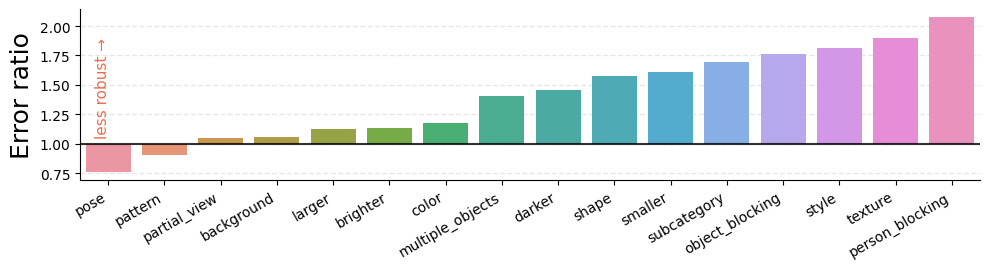

In [6]:
       
# Compute accuracies per factor
factor_accs = (correct/total).cpu().detach().numpy()
results = pd.DataFrame({'Factor': FACTORS, 'acc': factor_accs}).sort_values('acc', ascending=False)

# Compute error ratios per factor
results['Error ratio'] = (1 - results['acc']) / (1-(correct.sum()/total.sum()).item())

# Plot results
plots.plot_bar_plot(results, x='Factor', y='Error ratio')
plt.show()